<a href="https://colab.research.google.com/github/dariashcherbakovaaa/pet-projects/blob/main/Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

kaggle.json is ready


In [2]:
import json
import os

kaggle_credentials = {
    "username": "dariashcherbakovaa",
    "key": "14fa7c959e2bd1f57d0dc6bd7a28b12a"
}
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)

with open(os.path.expanduser("~/.kaggle/kaggle.json"), "w") as f:
    json.dump(kaggle_credentials, f)
os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)

print("kaggle.json is ready")


!pip install kaggle
!mkdir -p ~/.kaggle
!mv /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c ieee-fraud-detection
!unzip ieee-fraud-detection.zip -d ./ieee-fraud-detection

mv: cannot stat '/content/kaggle.json': No such file or directory
ieee-fraud-detection.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  ieee-fraud-detection.zip
replace ./ieee-fraud-detection/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [3]:
import pandas as pd
import numpy as np
import re
import seaborn as sns

from scipy.stats import zscore

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

### Data - Transaction Table

Categorical Features - Transaction

* ProductCD
* card1 - card6
* addr1, addr2
* P_emaildomain
* R_emaildomain
* M1 - M9


* TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
* TransactionAMT: transaction payment amount in USD
* ProductCD: product code, the product for each transaction
card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
* addr: address
* dist: distance
* P_ and (R__) emaildomain: purchaser and recipient email domain
* C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
* D1-D15: timedelta, such as days between previous transaction, etc.
* M1-M9: match, such as names on card and address, etc.
* Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

In [4]:
df_transaction = pd.read_csv('/content/ieee-fraud-detection/train_transaction.csv', index_col='TransactionID')
df_transaction.head(10)

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
TransactionID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.

## Warm-Up 1: Data exploration & Undersatnding

### Data size and structure

In [9]:
print(f'The size of data: {df_transaction.shape}')
print(df_transaction.dtypes.value_counts())

The size of data: (590540, 393)
float64    376
object      14
int64        3
Name: count, dtype: int64


The size of database is 590540 rows and 393 columns. There are 379 numeric variables and 14 categorical variables

In [11]:
num_cols = df_transaction.select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_cols = df_transaction.select_dtypes(include=['object']).columns.tolist()
binary_cols = [col for col in df_transaction.columns if df_transaction[col].nunique() == 2]

print("Numerical columns:", len(num_cols))
print('-'*50)
print("Categorical columns:", len(cat_cols))
print(cat_cols)
print('-'*50)
print("Binary columns:", len(binary_cols))
print(binary_cols)

Numerical columns: 379
--------------------------------------------------
Categorical columns: 14
['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']
--------------------------------------------------
Binary columns: 16
['isFraud', 'M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V14', 'V41', 'V65', 'V88', 'V107', 'V305']


In [12]:
for col in cat_cols:
  print(f'For {col} unique values: {df_transaction[col].nunique()}')

# df_transaction[object_cols].nunique()

For ProductCD unique values: 5
For card4 unique values: 4
For card6 unique values: 4
For P_emaildomain unique values: 59
For R_emaildomain unique values: 60
For M1 unique values: 2
For M2 unique values: 2
For M3 unique values: 2
For M4 unique values: 3
For M5 unique values: 2
For M6 unique values: 2
For M7 unique values: 2
For M8 unique values: 2
For M9 unique values: 2


### Distribution of key variables



TransactionAmt

In [17]:
df_transaction['TransactionAmt'].describe()

,TransactionAmt
count,590540.000000
mean,135.027176
std,239.162522
min,0.251000
25%,43.321000
50%,68.769000
75%,125.000000
max,31937.391000


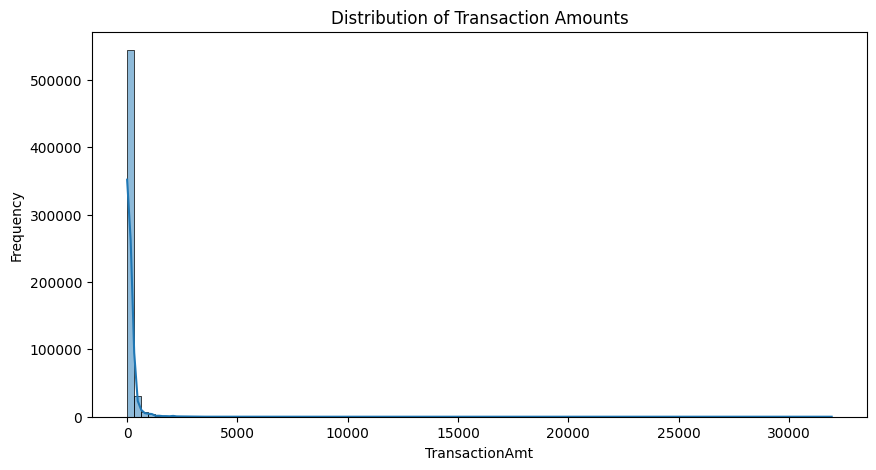

In [18]:
plt.figure(figsize=(10, 5))
sns.histplot(df_transaction['TransactionAmt'], bins=100, kde=True)
plt.title('Distribution of Transaction Amounts')
plt.xlabel('TransactionAmt')
plt.ylabel('Frequency')
plt.show()

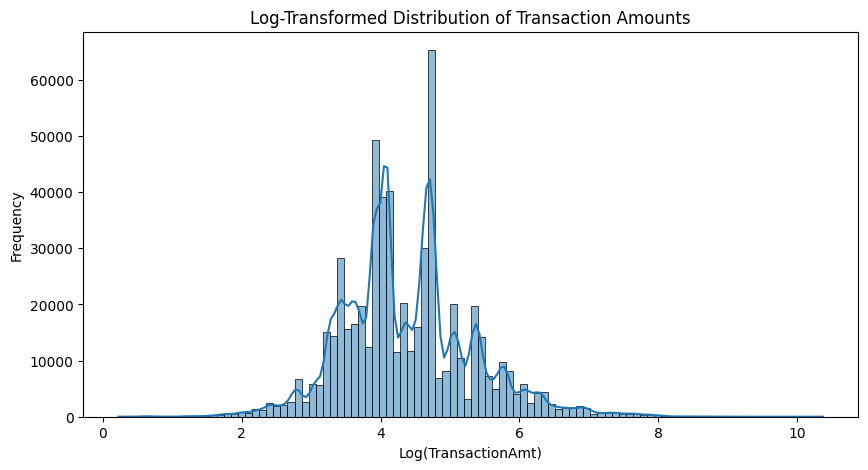

In [19]:
df_transaction['LogTransactionAmt'] = np.log1p(df_transaction['TransactionAmt'])

plt.figure(figsize=(10, 5))
sns.histplot(df_transaction['LogTransactionAmt'], bins=100, kde=True)
plt.title('Log-Transformed Distribution of Transaction Amounts')
plt.xlabel('Log(TransactionAmt)')
plt.ylabel('Frequency')
plt.show()


In [ ]:
df_transaction.groupby('isFraud')['TransactionAmt'].median()

,TransactionAmt
isFraud,
0,68.5
1,75.0


In [ ]:
df_transaction.groupby('isFraud')['TransactionAmt'].mean()

,TransactionAmt
isFraud,
0,134.511665
1,149.244779


In [ ]:
df_transaction.groupby('isFraud')['TransactionAmt'].apply(lambda x: x.value_counts().index[0]).reset_index()

,isFraud,TransactionAmt
0,0,59.0
1,1,117.0


card4

In [20]:
print(df_transaction['card4'].value_counts(dropna=False))

card4
visa                384767
mastercard          189217
american express      8328
discover              6651
NaN                   1577
Name: count, dtype: int64


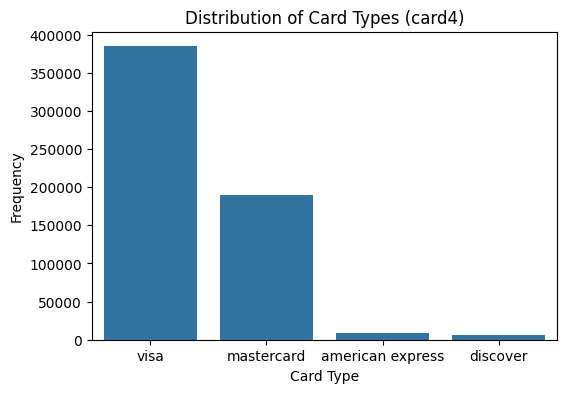

In [21]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df_transaction, x='card4', order=df_transaction['card4'].value_counts().index)
plt.title('Distribution of Card Types (card4)')
plt.xlabel('Card Type')
plt.ylabel('Frequency')
plt.show()


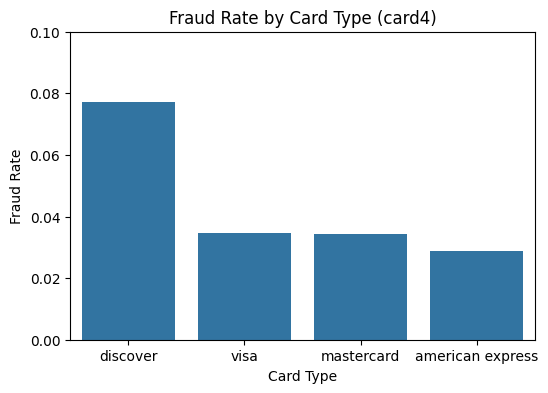

In [23]:
card4_fraud = df_transaction.groupby('card4')['isFraud'].mean().sort_values(ascending=False)

plt.figure(figsize=(6, 4))
sns.barplot(x=card4_fraud.index, y=card4_fraud.values)
plt.title('Fraud Rate by Card Type (card4)')
plt.ylabel('Fraud Rate')
plt.xlabel('Card Type')
plt.ylim(0, 0.1)  # подстрой под свои значения
plt.show()

ProductCD

In [31]:
print(df_transaction['ProductCD'].value_counts())

ProductCD
W    439670
C     68519
R     37699
H     33024
S     11628
Name: count, dtype: int64


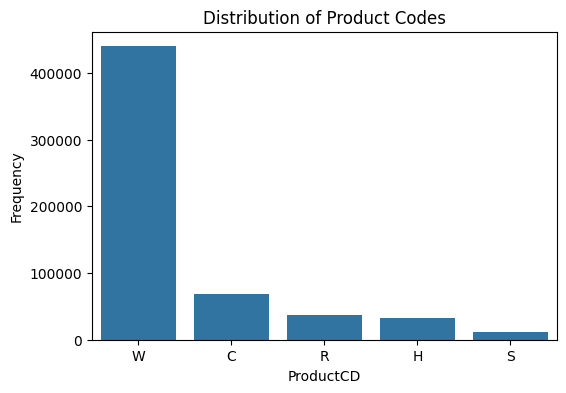

In [24]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df_transaction, x='ProductCD', order=df_transaction['ProductCD'].value_counts().index)
plt.title('Distribution of Product Codes')
plt.xlabel('ProductCD')
plt.ylabel('Frequency')
plt.show()

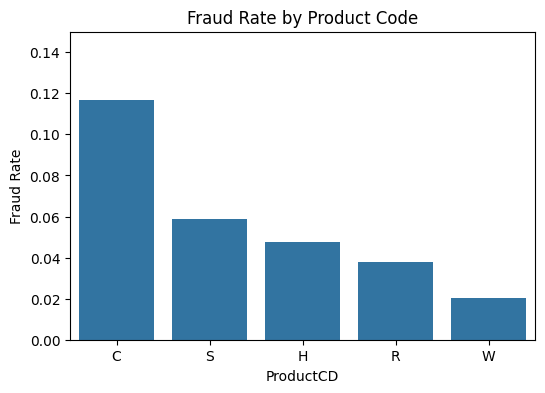

In [29]:
product_fraud = df_transaction.groupby('ProductCD')['isFraud'].mean().sort_values(ascending=False)

plt.figure(figsize=(6, 4))
sns.barplot(x=product_fraud.index, y=product_fraud.values)
plt.title('Fraud Rate by Product Code')
plt.ylabel('Fraud Rate')
plt.xlabel('ProductCD')
plt.ylim(0, 0.15)
plt.show()


### Missing values


In [5]:
for col in df_transaction.columns:
    missing_percentage = df_transaction[col].isna().sum() / df_transaction.shape[0] * 100
    if missing_percentage > 0.01:
        print(f'The % of missing value in {col} is {missing_percentage:.1f}%')

The % of missing value in card2 is 1.5%
The % of missing value in card3 is 0.3%
The % of missing value in card4 is 0.3%
The % of missing value in card5 is 0.7%
The % of missing value in card6 is 0.3%
The % of missing value in addr1 is 11.1%
The % of missing value in addr2 is 11.1%
The % of missing value in dist1 is 59.7%
The % of missing value in dist2 is 93.6%
The % of missing value in P_emaildomain is 16.0%
The % of missing value in R_emaildomain is 76.8%
The % of missing value in D1 is 0.2%
The % of missing value in D2 is 47.5%
The % of missing value in D3 is 44.5%
The % of missing value in D4 is 28.6%
The % of missing value in D5 is 52.5%
The % of missing value in D6 is 87.6%
The % of missing value in D7 is 93.4%
The % of missing value in D8 is 87.3%
The % of missing value in D9 is 87.3%
The % of missing value in D10 is 12.9%
The % of missing value in D11 is 47.3%
The % of missing value in D12 is 89.0%
The % of missing value in D13 is 89.5%
The % of missing value in D14 is 89.5%
Th

In [9]:
keep_cols = ['TransactionDT', 'TransactionAmt', 'isFraud','ProductCD',
             'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
             'addr1', 'addr2', 'dist1', 'P_emaildomain', 'R_emaildomain',
             'D1', 'D2', 'D10','M1', 'M2', 'M3', 'M4', 'M5', 'M6']

df = df_transaction[keep_cols].copy()
print("The size of data becomes:", df.shape)

The size of data becomes: (590540, 24)


In [10]:
df.isna().sum()

,0
TransactionDT,0
TransactionAmt,0
isFraud,0
ProductCD,0
card1,0
card2,8933
card3,1565
card4,1577
card5,4259
card6,1571


In [11]:
cat_cols = ['card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6']
for col in cat_cols:
    df[col] = df[col].fillna("missing")

for col in ['card2', 'card3', 'card5', 'D1']:
    df[col] = df[col].fillna(df[col].median())

for col in ['dist1', 'D2', 'D10']:
    df[col] = df[col].fillna(999)

df['addr1'] = df['addr1'].fillna("missing")
df['addr2'] = df['addr2'].fillna("missing")

df.sample(10)

,TransactionDT,TransactionAmt,isFraud,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,D1,D2,D10,M1,M2,M3,M4,M5,M6
TransactionID,,,,,,,,,,,,,,,,,,,,,,,,
3032261,1095175,57.950,0,W,9500,321.0,150.0,visa,226.0,debit,272.0,87.0,999.0,aol.com,missing,108.0,94.0,109.0,missing,missing,missing,missing,missing,T
3019305,789386,50.000,0,H,2768,143.0,150.0,visa,195.0,debit,205.0,87.0,999.0,gmail.com,missing,0.0,999.0,999.0,missing,missing,missing,missing,missing,missing
3262432,6704103,150.000,0,R,6262,399.0,150.0,american express,132.0,credit,433.0,87.0,999.0,aol.com,gmail.com,0.0,999.0,0.0,missing,missing,missing,missing,missing,missing
3164635,3873186,35.950,0,W,12544,321.0,150.0,visa,226.0,debit,337.0,87.0,999.0,yahoo.com,missing,235.0,235.0,235.0,missing,missing,missing,missing,missing,F
3309838,8012459,171.000,0,W,7919,194.0,150.0,mastercard,166.0,debit,494.0,87.0,999.0,icloud.com,missing,0.0,999.0,0.0,T,T,T,M0,T,F
3349652,8988157,57.950,0,W,8695,170.0,150.0,visa,226.0,credit,476.0,87.0,106.0,gmail.com,missing,177.0,177.0,236.0,T,T,F,missing,missing,F
3512360,13810443,12.358,0,C,16136,204.0,185.0,visa,138.0,debit,missing,missing,999.0,gmail.com,gmail.com,0.0,999.0,0.0,missing,missing,missing,M2,missing,missing
3042860,1293529,59.000,0,W,9046,321.0,150.0,visa,226.0,debit,315.0,87.0,999.0,aol.com,missing,315.0,315.0,429.0,missing,missing,missing,M1,F,T
3329379,8446005,7.855,0,C,1556,314.0,150.0,mastercard,224.0,debit,missing,missing,999.0,gmail.com,gmail.com,0.0,999.0,0.0,missing,missing,missing,M2,missing,missing


### Outliers

In [14]:
df['TransactionAmt'].describe()

,TransactionAmt
count,590540.000000
mean,135.027176
std,239.162522
min,0.251000
25%,43.321000
50%,68.769000
75%,125.000000
max,31937.391000


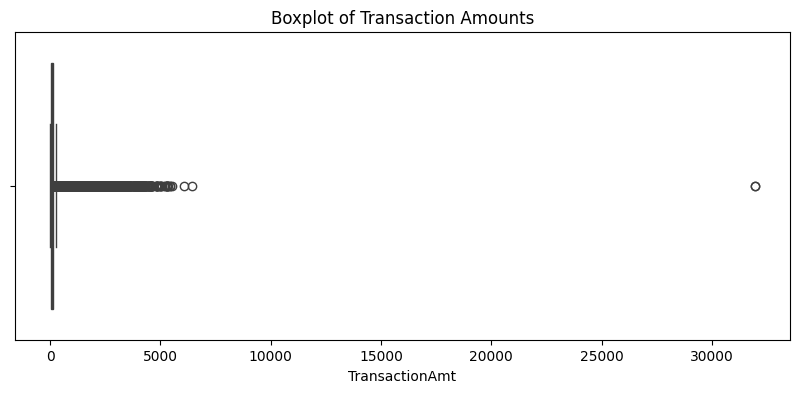

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 4))
sns.boxplot(x=df['TransactionAmt'])
plt.title("Boxplot of Transaction Amounts")
plt.xlabel("TransactionAmt")
plt.show()

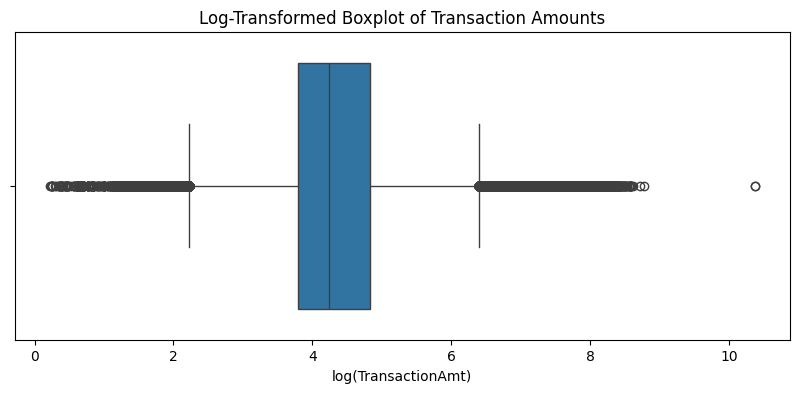

In [17]:
import numpy as np

plt.figure(figsize=(10, 4))
sns.boxplot(x=np.log1p(df['TransactionAmt']))
plt.title("Log-Transformed Boxplot of Transaction Amounts")
plt.xlabel("log(TransactionAmt)")
plt.show()

In [19]:
Q1 = df['TransactionAmt'].quantile(0.25)
Q3 = df['TransactionAmt'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['TransactionAmt'] < lower_bound) |
                      (df['TransactionAmt'] > upper_bound)]

print(f"Количество выбросов: {len(outliers)}")
print(f"Максимальная сумма транзакции: {df['TransactionAmt'].max()}")


Количество выбросов: 66482
Максимальная сумма транзакции: 31937.391


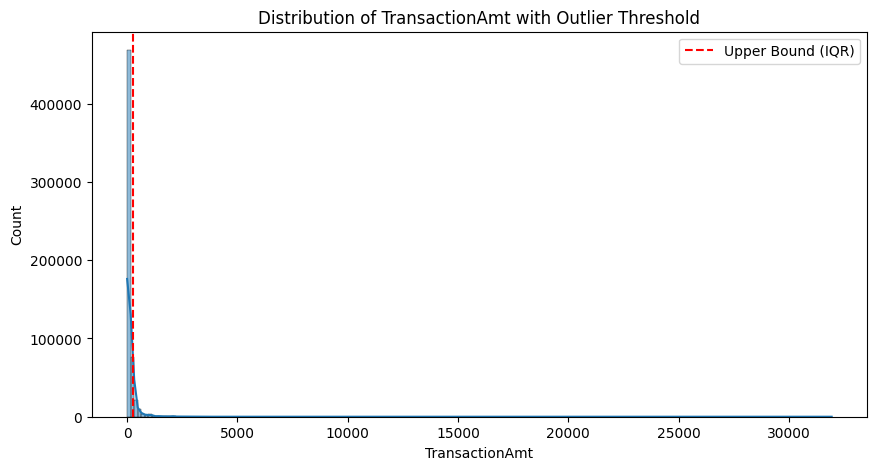

In [20]:
plt.figure(figsize=(10, 5))
sns.histplot(df['TransactionAmt'], bins=200, kde=True)
plt.axvline(upper_bound, color='red', linestyle='--', label='Upper Bound (IQR)')
plt.title("Distribution of TransactionAmt with Outlier Threshold")
plt.xlabel("TransactionAmt")
plt.legend()
plt.show()


In [28]:
df['log_TransactionAmt'] = np.log1p(df['TransactionAmt'])

Q1 = df['log_TransactionAmt'].quantile(0.25)
Q3 = df['log_TransactionAmt'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outlier_iqr = df[(df['log_TransactionAmt'] < lower_bound) | (df['log_TransactionAmt'] > upper_bound)]
print(f'# Outliers with IQR: {len(outlier_iqr)}')

df['z_score'] = zscore(df['log_TransactionAmt'])
outlier_z = df[df['z_score'].abs() > 3]
print(f'# Outliers with zscore: {len(outlier_z)}')

from sklearn.ensemble import IsolationForest

iso = IsolationForest(contamination=0.01, random_state=42)
df['anomaly'] = iso.fit_predict(df[['log_TransactionAmt']])

# -1 = выброс, 1 = нормальное значение
outlier_forest = df[df['anomaly'] == -1]
print(f'# Outliers with IsolationForest: {len(outlier_forest)}')

# Outliers with IQR: 20639
# Outliers with zscore: 5135
# Outliers with IsolationForest: 5787


In [29]:
df['outlier_iqr'] = ((df['log_TransactionAmt'] < lower_bound) | (df['log_TransactionAmt'] > upper_bound)).astype(int)
df['outlier_z'] = (df['z_score'].abs() > 3).astype(int)
df[['outlier_iqr', 'outlier_z', 'anomaly']].value_counts()

outlier_iqr  outlier_z  anomaly
0            0           1         569901
1            0           1          13809
             1          -1           4092
             0          -1           1695
             1           1           1043
Name: count, dtype: int64

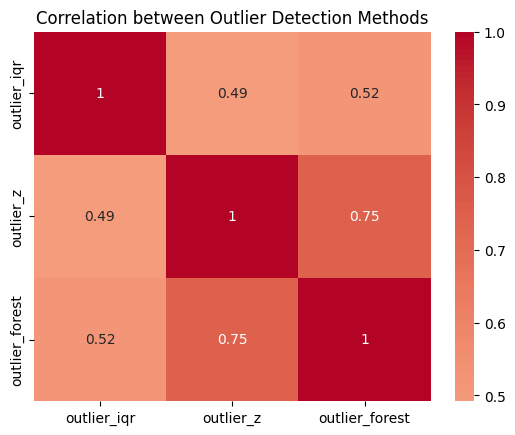

In [31]:
df['outlier_forest'] = (df['anomaly'] == -1).astype(int)

# Пересечения
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(
    df[['outlier_iqr', 'outlier_z', 'outlier_forest']].corr(),
    annot=True, cmap='coolwarm', center=0
)
plt.title("Correlation between Outlier Detection Methods")
plt.show()


In [34]:
outliers_iqr = df[df['outlier_iqr'] == 1]
fraud_rate_outliers = outliers_iqr['isFraud'].mean()

print(f"Fraud rate among IQR outliers: {fraud_rate_outliers:.2%}")

outliers_z = df[df['outlier_z'] == 1]
fraud_rate_outliers = outliers_z['isFraud'].mean()

print(f"Fraud rate among Z-score outliers: {fraud_rate_outliers:.2%}")


outliers_forest = df[df['outlier_forest'] == 1]
fraud_rate_outliers = outliers_forest['isFraud'].mean()

print(f"Fraud rate among Forest outliers: {fraud_rate_outliers:.2%}")


Fraud rate among IQR outliers: 5.14%
Fraud rate among Z-score outliers: 2.82%
Fraud rate among Forest outliers: 3.99%


In [35]:
df['isFraud_str'] = df['isFraud'].map({0: 'Not Fraud', 1: 'Fraud'})
df['outlier_iqr_str'] = df['outlier_iqr'].map({0: 'Normal', 1: 'Outlier'})

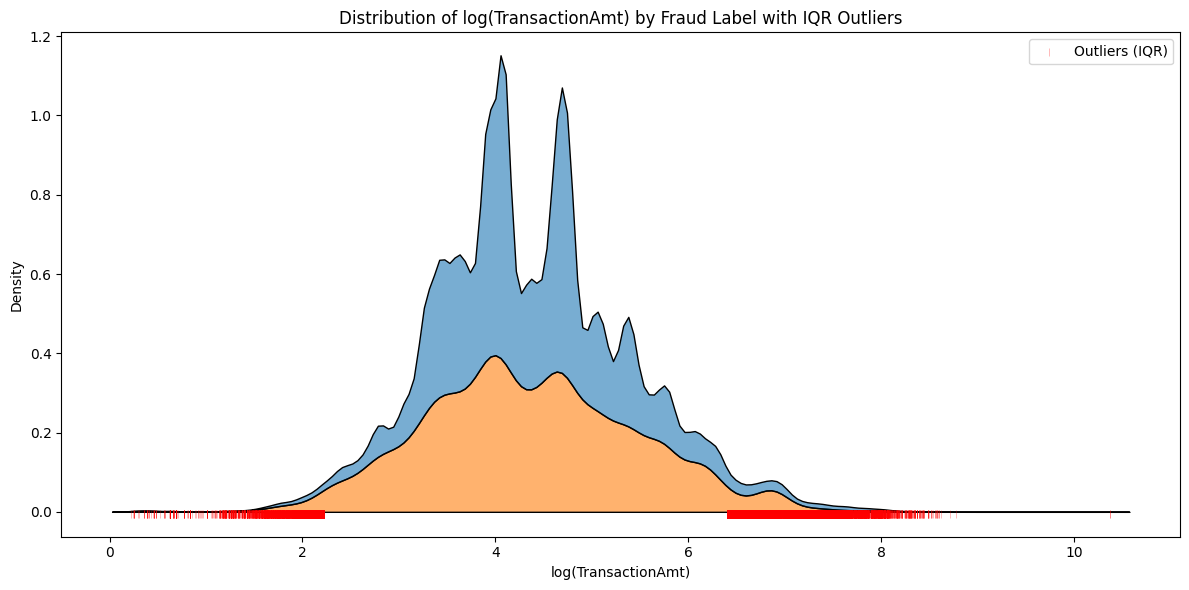

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.kdeplot(
    data=df,
    x='log_TransactionAmt',
    hue='isFraud_str',
    multiple='stack',
    common_norm=False,
    alpha=0.6
)
sns.scatterplot(
    data=df[df['outlier_iqr'] == 1],
    x='log_TransactionAmt',
    y=[-0.005]*len(df[df['outlier_iqr'] == 1]),  # небольшой сдвиг вниз
    color='red',
    label='Outliers (IQR)',
    marker='|',
    alpha=0.4
)
plt.title("Distribution of log(TransactionAmt) by Fraud Label with IQR Outliers")
plt.xlabel("log(TransactionAmt)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

In [39]:
mask_outliers = (df['outlier_iqr'] == 1) & (df['anomaly'] == -1) & (df['z_score'].abs() > 3)
df['isOutlier'] = mask_outliers.astype(int)

### Correlations

In [45]:

# Загрузим только нужные колонки
cols = ['TransactionAmt'] + [f'C{i}' for i in range(1, 15)] + [f'D{i}' for i in range(1, 16)]
full_transaction = pd.read_csv('/content/ieee-fraud-detection/train_transaction.csv', usecols=cols)

# Заполним пропуски медианой
full_transaction_median = full_transaction.fillna(full_transaction.median(numeric_only=True))


In [46]:
corr_result = full_transaction_median.corr()['TransactionAmt'].drop('TransactionAmt').sort_values(key=abs, ascending=False)
print(corr_result)

D12   -0.054481
D6    -0.049285
D15   -0.045208
D1    -0.040172
C13   -0.040034
D11   -0.039714
D14   -0.035519
D9     0.032997
D4    -0.032520
C5    -0.030560
C9    -0.030021
D10   -0.029486
D13   -0.027756
D7    -0.027228
C14   -0.022435
D2    -0.021790
C2    -0.018468
C1    -0.017722
C11   -0.017313
C12   -0.017135
C7    -0.017061
C6    -0.016982
C10   -0.015958
C8    -0.014820
D8    -0.013607
C4    -0.010148
D3    -0.009578
D5    -0.005721
C3    -0.004798
Name: TransactionAmt, dtype: float64


<ipython-input-47-fa22169dccd3>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_result.values, y=corr_result.index, palette='coolwarm')


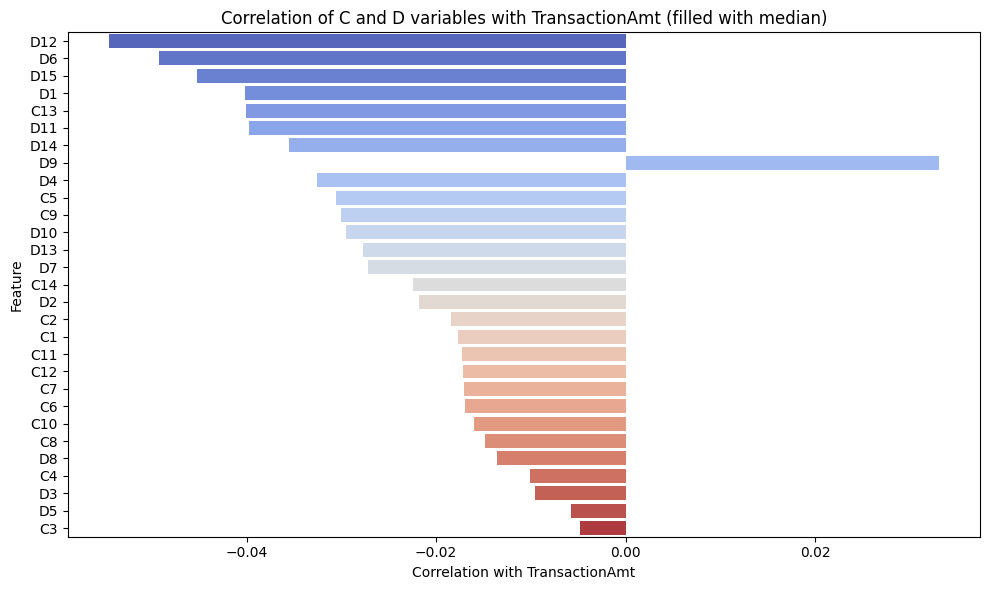

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(x=corr_result.values, y=corr_result.index, palette='coolwarm')
plt.title('Correlation of C and D variables with TransactionAmt (filled with median)')
plt.xlabel('Correlation with TransactionAmt')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


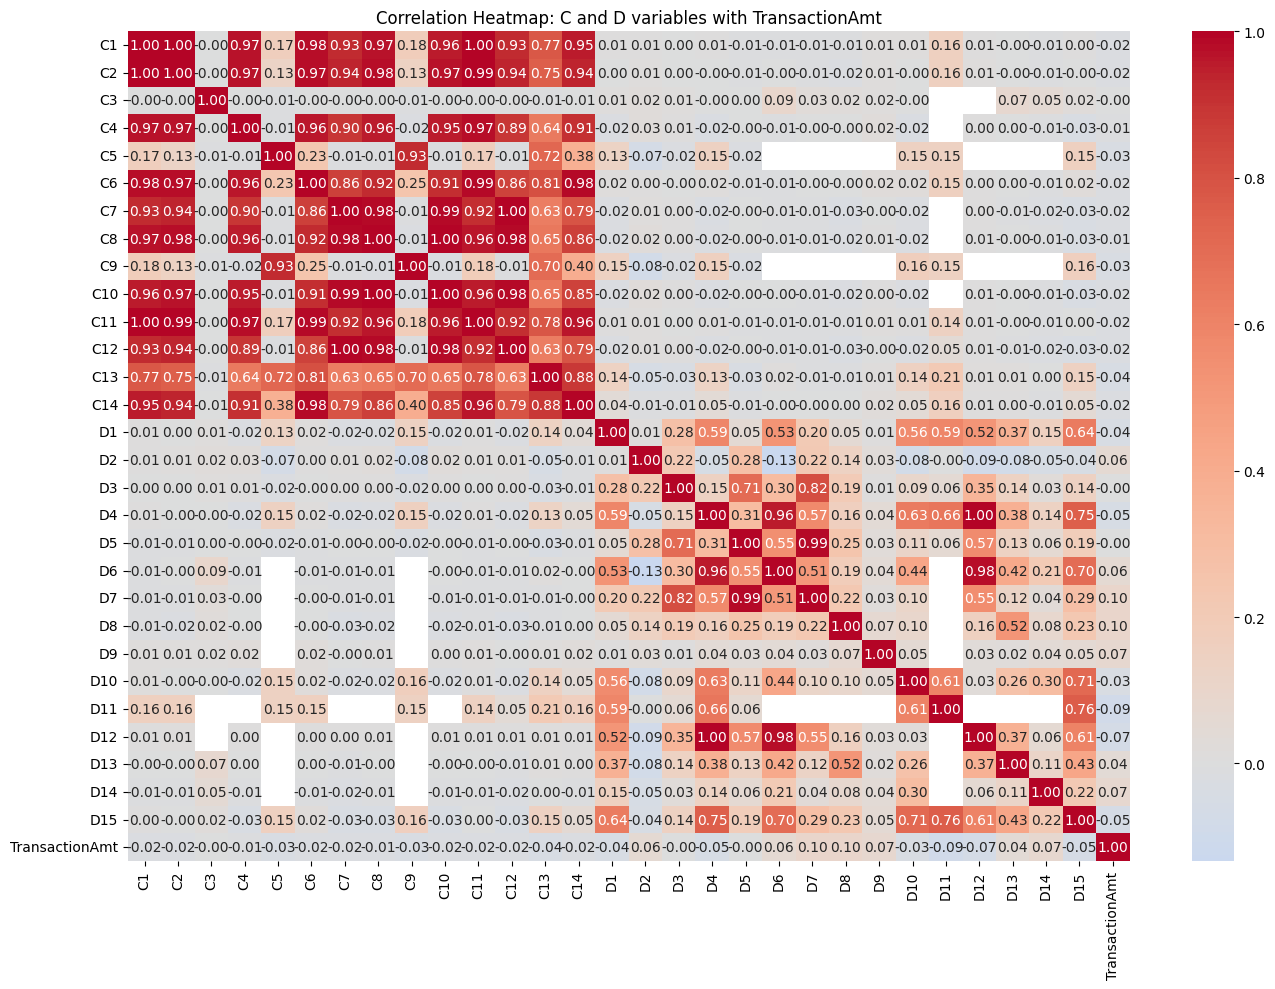

In [48]:
# Заполняем пропуски медианой
df_filled = full_transaction.fillna(df.median(numeric_only=True))

# Считаем корреляции
corr_matrix = df_filled.corr()

# Оставляем только C и D переменные + TransactionAmt
cd_cols = [col for col in corr_matrix.columns if col.startswith('C') or col.startswith('D')] + ['TransactionAmt']
cd_corr = corr_matrix.loc[cd_cols, cd_cols]

# Рисуем heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(cd_corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Heatmap: C and D variables with TransactionAmt")
plt.tight_layout()
plt.show()

## Warm-Up 2: Feature Engineering

### Transformation of TransactionDT

In [ ]:
start_date = pd.to_datetime("2017-12-01")

df_transaction['TransactionDate'] = pd.to_datetime("2017-12-01") + pd.to_timedelta(df_transaction['TransactionDT'], unit='s')
df_transaction['TransactionDate'].sample(10)

,TransactionDate
TransactionID,
3393801,2018-03-29 21:28:39
3186822,2018-01-22 16:25:57
3563109,2018-05-27 01:45:37
3342572,2018-03-12 20:45:58
3257008,2018-02-14 19:36:48
3370684,2018-03-22 03:45:07
3035399,2017-12-14 05:18:30
3440069,2018-04-13 21:52:26
3220772,2018-02-02 23:27:42


In [ ]:
df_transaction['Hour'] = df_transaction['TransactionDate'].dt.hour
df_transaction['Weekday'] = df_transaction['TransactionDate'].dt.weekday         # 0 = Понедельник, 6 = Воскресенье
df_transaction['IsWeekend'] = df_transaction['Weekday'].isin([5, 6])
df_transaction['Month'] = df_transaction['TransactionDate'].dt.month
df_transaction['IsMonthStart'] = df_transaction['TransactionDate'].dt.is_month_start
df_transaction['Day'] = df_transaction['TransactionDate'].dt.day
df_transaction['DayOfYear'] = df_transaction['TransactionDate'].dt.dayofyear
df_transaction['WeekOfYear'] = df_transaction['TransactionDate'].dt.isocalendar().week

In [ ]:
def get_time_of_day(hour):
    if 0 <= hour < 6:
        return 'Night'
    elif 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    else:
        return 'Evening'

df_transaction['TimeOfDay'] = df_transaction['Hour'].apply(get_time_of_day)
df_transaction['Hour_sin'] = np.sin(2 * np.pi * df_transaction['Hour'] / 24)
df_transaction['Hour_cos'] = np.cos(2 * np.pi * df_transaction['Hour'] / 24)

df_transaction['Weekday_sin'] = np.sin(2 * np.pi * df_transaction['Weekday'] / 7)
df_transaction['Weekday_cos'] = np.cos(2 * np.pi * df_transaction['Weekday'] / 7)

In [ ]:
df_transaction['IsWeekend'] = df_transaction['Weekday'].isin([5, 6])

def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

df_transaction['Season'] = df_transaction['Month'].apply(get_season)

### Email domains

In [ ]:
df_transaction['P_emaildomain'].unique()

array([nan, 'gmail.com', 'outlook.com', 'yahoo.com', 'mail.com',
       'anonymous.com', 'hotmail.com', 'verizon.net', 'aol.com', 'me.com',
       'comcast.net', 'optonline.net', 'cox.net', 'charter.net',
       'rocketmail.com', 'prodigy.net.mx', 'embarqmail.com', 'icloud.com',
       'live.com.mx', 'gmail', 'live.com', 'att.net', 'juno.com',
       'ymail.com', 'sbcglobal.net', 'bellsouth.net', 'msn.com', 'q.com',
       'yahoo.com.mx', 'centurylink.net', 'servicios-ta.com',
       'earthlink.net', 'hotmail.es', 'cfl.rr.com', 'roadrunner.com',
       'netzero.net', 'gmx.de', 'suddenlink.net', 'frontiernet.net',
       'windstream.net', 'frontier.com', 'outlook.es', 'mac.com',
       'netzero.com', 'aim.com', 'web.de', 'twc.com', 'cableone.net',
       'yahoo.fr', 'yahoo.de', 'yahoo.es', 'sc.rr.com', 'ptd.net',
       'live.fr', 'yahoo.co.uk', 'hotmail.fr', 'hotmail.de',
       'hotmail.co.uk', 'protonmail.com', 'yahoo.co.jp'], dtype=object)

In [ ]:
df_transaction['email_base'] = df_transaction['P_emaildomain'].str.extract(r'^([^\.]+)')
df_transaction['email_base'].unique()

array([nan, 'gmail', 'outlook', 'yahoo', 'mail', 'anonymous', 'hotmail',
       'verizon', 'aol', 'me', 'comcast', 'optonline', 'cox', 'charter',
       'rocketmail', 'prodigy', 'embarqmail', 'icloud', 'live', 'att',
       'juno', 'ymail', 'sbcglobal', 'bellsouth', 'msn', 'q',
       'centurylink', 'servicios-ta', 'earthlink', 'cfl', 'roadrunner',
       'netzero', 'gmx', 'suddenlink', 'frontiernet', 'windstream',
       'frontier', 'mac', 'aim', 'web', 'twc', 'cableone', 'sc', 'ptd',
       'protonmail'], dtype=object)

### Addresses and distances

### Binary variables